In [6]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import joblib

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version skforecast: 0.18.0
- Version scikit-learn: 1.7.2
- Version pandas: 2.3.3
- Version numpy: 2.2.6


In [2]:
try:
    df = pd.read_csv("../Datasets/accesos_biblioteca.csv")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'accesos_biblioteca.csv'")
    exit(1)

df

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?
0,2023-12-14,14,12,2023,2,953,0
1,2023-12-15,15,12,2023,2,549,0
2,2023-12-16,16,12,2023,2,71,0
3,2023-12-17,17,12,2023,2,0,1
4,2023-12-18,18,12,2023,2,739,0
...,...,...,...,...,...,...,...
506,2025-05-03,3,5,2025,1,0,1
507,2025-05-04,4,5,2025,1,0,1
508,2025-05-05,5,5,2025,1,2750,0
509,2025-05-06,6,5,2025,1,1866,0


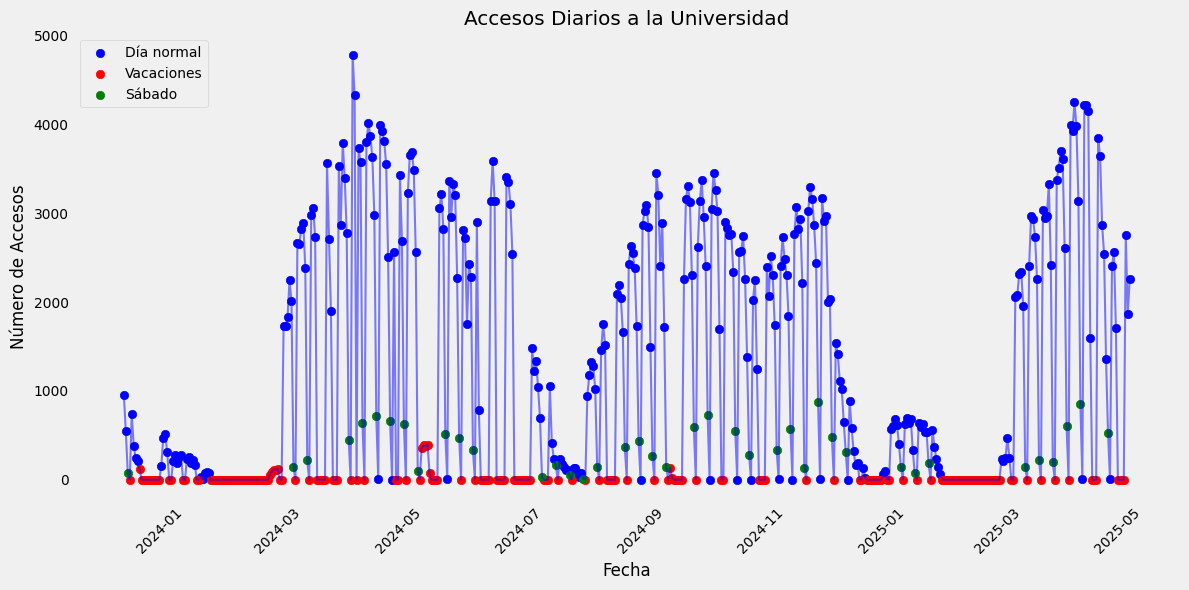

In [ ]:
df['Fecha'] = pd.to_datetime(df['Fecha'])

plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday != 5)
plt.scatter(df['Fecha'][no_vac_no_sab], df['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones
vac = (df['Vacaciones?'] == 1)
plt.scatter(df['Fecha'][vac], df['Accesos'][vac], color='r', label='Vacaciones')

# Puntos de sábados
sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday == 5)
plt.scatter(df['Fecha'][sab], df['Accesos'][sab], color='g', label='Sábado')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
X = df[['Vacaciones?', 'Día', 'Mes', 'Año']]
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 408
Datos de prueba: 103


In [10]:
if "modelo_RandomForest.pkl" not in os.listdir('../Archivos Auxiliares'):
    print("Entrenando el modelo Random Forest")
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train, y_train)

    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 5, 8, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f'Mejores parámetros: {grid_search.best_params_}')

    best_params = grid_search.best_params_
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, '../Archivos Auxiliares/modelo_RandomForest.pkl')
    print("Modelo guardado como '../Archivos Auxiliares/modelo_RandomForest.pkl'")
else:
    model = joblib.load('../Archivos Auxiliares/modelo_RandomForest.pkl')
    print("Modelo cargado desde 'Archivos Auxiliares/modelo_RandomForest.pkl'")

Entrenando el modelo Random Forest
Mejores parámetros: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Modelo guardado como '../Archivos Auxiliares/modelo_RandomForest.pkl'


In [11]:
predicted = model.predict(X_test)
predicted = np.maximum(predicted, 0)

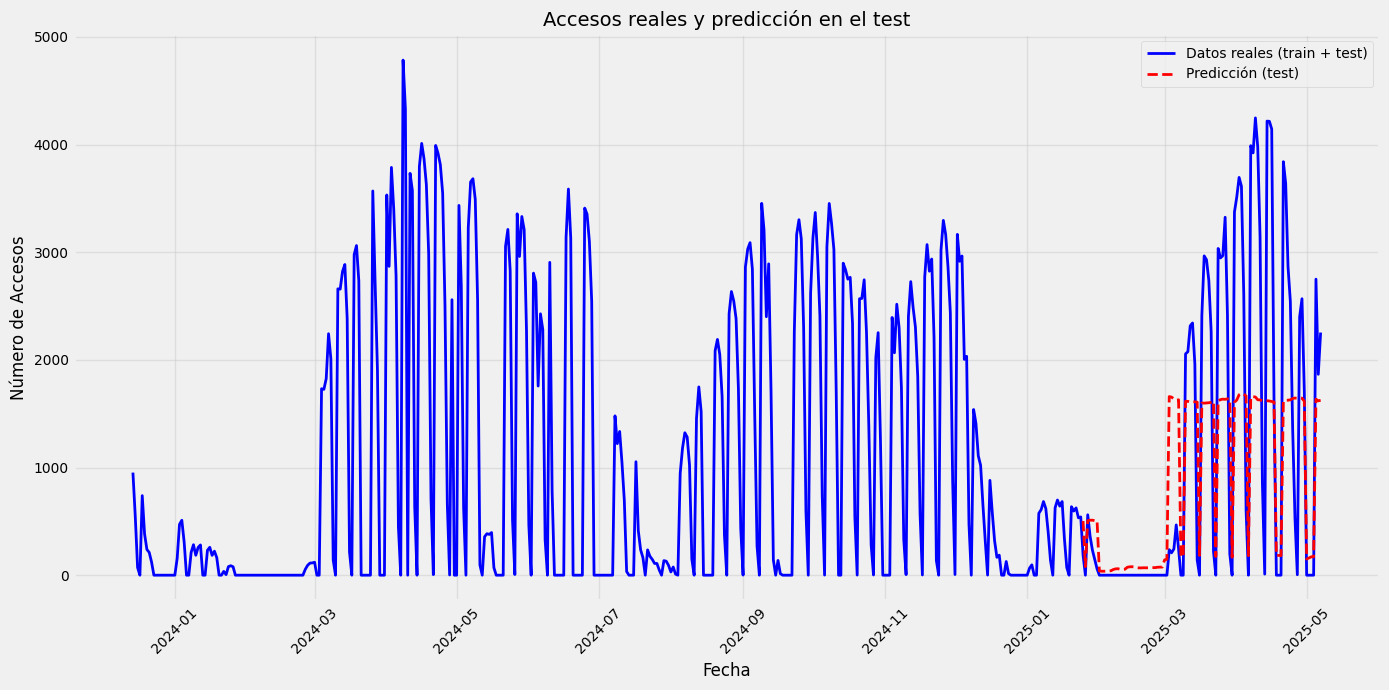

R²: 0.48
Error Cuadrático Medio (MSE): 1128978.94
Error Cuadrático Medio Raíz (RMSE): 1062.53
Error Absoluto Medio (MAE): 733.22


In [12]:
fechas = df['Fecha']
plt.figure(figsize=(14, 7))
plt.plot(fechas, df['Accesos'], label='Datos reales (train + test)', color='blue', linewidth=2)
plt.plot(fechas.loc[X_test.index], predicted, label='Predicción (test)', color='red', linestyle='--', linewidth=2)
plt.title('Accesos reales y predicción en el test', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")

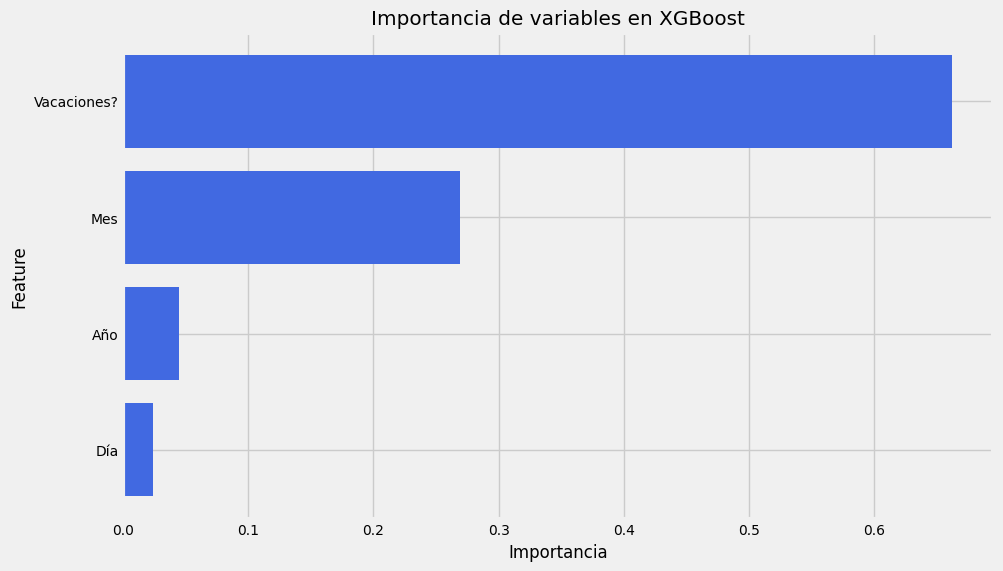

In [ ]:
importances = model.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='royalblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de variables en RandomForest")
plt.gca().invert_yaxis() 
plt.show()



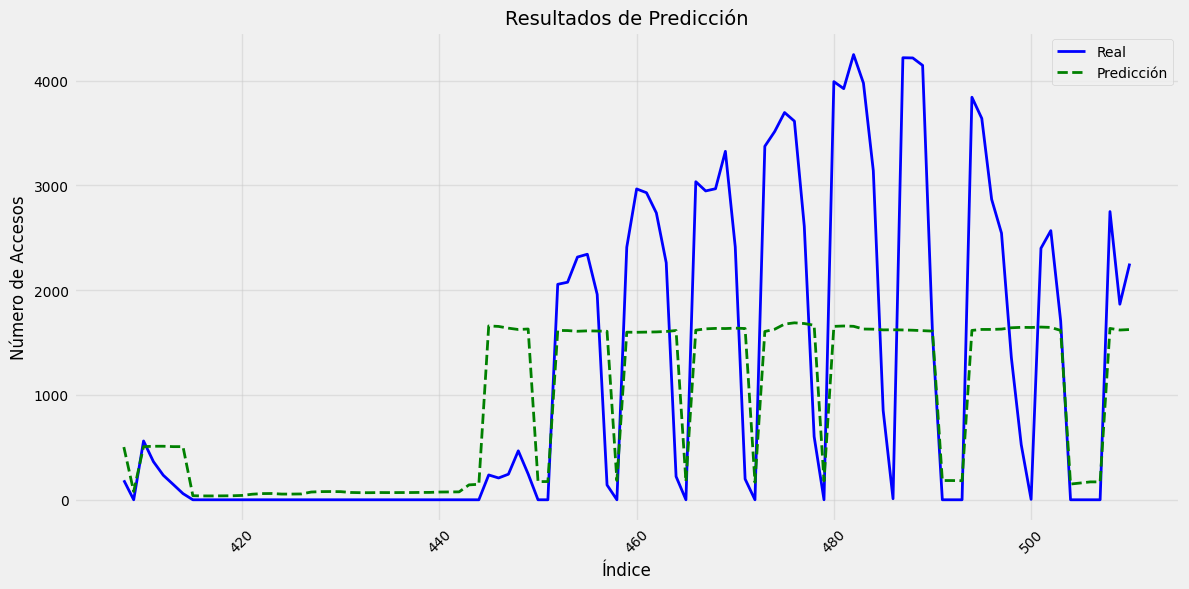

In [14]:
results_df = pd.DataFrame({
    'Índice': X_test.index,
    'Real': y_test,
    'Predicción': predicted
}).sort_values(by='Índice')

plt.figure(figsize=(12, 6))
plt.plot(results_df['Índice'], results_df['Real'], label='Real', color='blue', linewidth=2)
plt.plot(results_df['Índice'], results_df['Predicción'], label='Predicción', color='green', linestyle='--', linewidth=2)
plt.title('Resultados de Predicción', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()